In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy import optimize

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 10, 5
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size
plt.rcParams[  "image.cmap"   ] =   default_cmap

plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

# 1. Import data

In [3]:
df = pd.HDFStore('pmaps_corrected_descape_6206.h5')['']

# 2. Get an overview of energy spectra

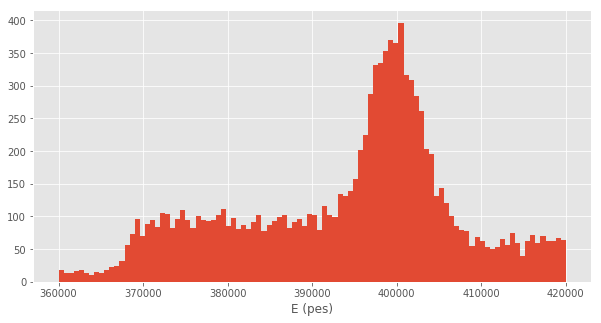

In [43]:
df['e'].hist(bins=nbins, range=(360e3, 420e3));
plt.xlabel('E (pes)', fontsize=12);

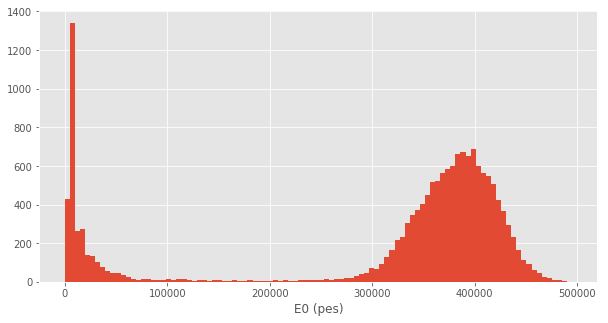

In [10]:
df['e0'].hist(bins=nbins);
plt.xlabel('E0 (pes)', fontsize=12);

# 3. Select descape region

In [15]:
Emax = 420e3
Emin = 380e3

In [16]:
descape_df = df[(df.e<Emax) & (df.e>Emin)]

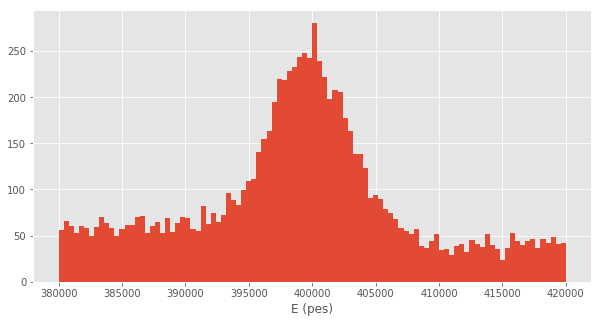

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

ydata, xdata, __ = ax.hist(descape_df['e'], bins=nbins, range = (Emin, Emax));
plt.xlabel('E (pes)', fontsize=12);

# 4. Fitting Cs photopeak

We perform a gaussian fit for the photopeak and assume a linear fit for background

$$F(E) = A e^{-(E-E_{ph})^2/2\sigma^2} + m(E-Emin) + c$$

In [18]:
def F(E, Eph, sig, A, m, c):
    return A * np.e**(-(E-Eph)**2/(2*sig**2)) + m*(E-Emin) + c

def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

In [23]:
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [400e3, 1e3, 2e2, -1, 200]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))

In [24]:
Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

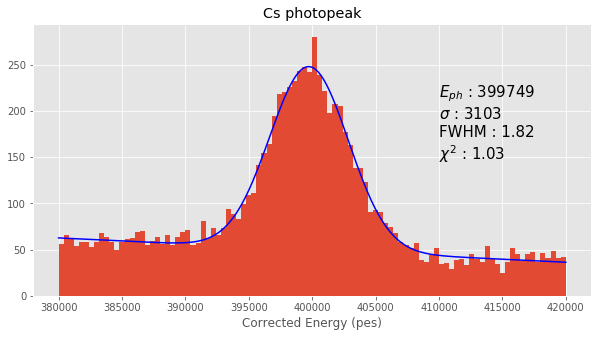

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(descape_df['e'], bins=nbins);
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'b');

t = (r"$E_{{ph}}$ : {}"       .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" . format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(410e3, 150, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('Cs photopeak');

In [29]:
print('Extrapolated FWHM:',sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.9468984774561009


# 5. Searching correlations

## 5.1. Corrected Energy correlations

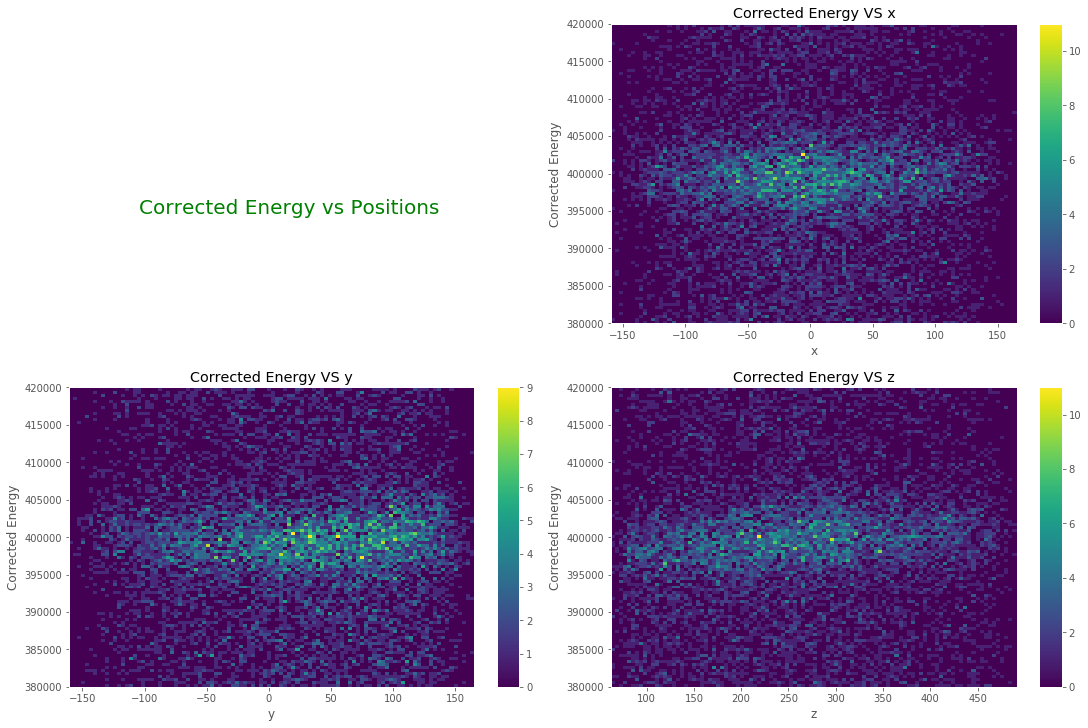

In [31]:
fig_ep = plt.figure(figsize =[15, 10] ,constrained_layout=True)

gs_ep = gridspec.GridSpec(2, 2, figure=fig_ep)

textpos = gs_ep[0, 0].get_position(fig_ep).get_points()
plt.figtext(textpos[0,0], (textpos[0,1] + textpos[1, 1])/2., 
            s='Corrected Energy vs Positions', figure=fig_ep, fontsize=20, color='green')

ax_ex = fig_ep.add_subplot(gs_ep[0, 1])
hist_ex = ax_ex.hist2d(descape_df['x'], descape_df['e'] , bins=nbins);
ax_ex.set_xlabel('x');
ax_ex.set_ylabel('Corrected Energy');
ax_ex.set_title('Corrected Energy VS x');
cbar_ex = fig_ep.colorbar(hist_ex[3], ax = ax_ex)

ax_ey = fig_ep.add_subplot(gs_ep[1, 0])
hist_ey = ax_ey.hist2d(descape_df['y'], descape_df['e'] , bins=nbins);
ax_ey.set_xlabel('y');
ax_ey.set_ylabel('Corrected Energy');
ax_ey.set_title('Corrected Energy VS y');
cbar_ey = fig_ep.colorbar(hist_ey[3], ax = ax_ey)

ax_ez = fig_ep.add_subplot(gs_ep[1, 1])
hist_ez = ax_ez.hist2d(descape_df['z'], descape_df['e'] , bins=nbins);
ax_ez.set_xlabel('z');
ax_ez.set_ylabel('Corrected Energy');
ax_ez.set_title('Corrected Energy VS z');
cbar_ez = fig_ep.colorbar(hist_ez[3], ax = ax_ez)

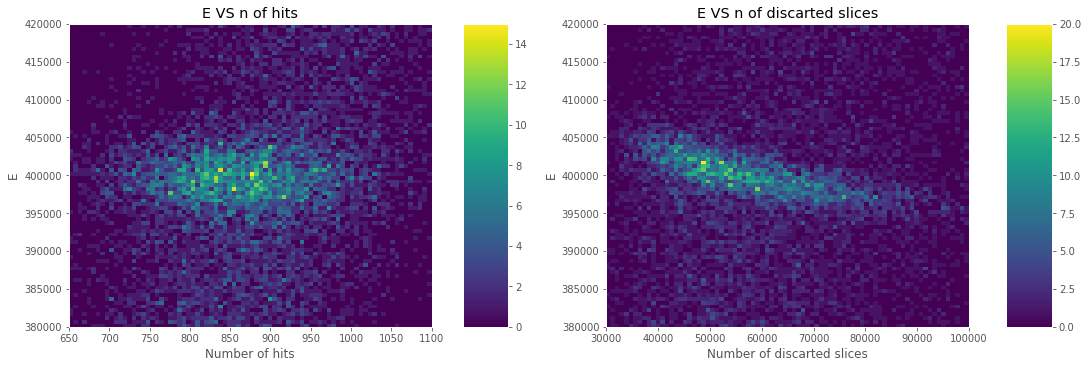

In [39]:
fig_e = plt.figure(figsize=[15, 5], constrained_layout=True)

gs_e = gridspec.GridSpec(1, 2, figure=fig_e)

ax_enhits = fig_e.add_subplot(gs_e[0])
hist_enhits = ax_enhits.hist2d(descape_df['nhits'], descape_df['e'] , bins=.8*nbins, range=((650, 1100),(Emin, Emax)));
ax_enhits.set_xlabel('Number of hits');
ax_enhits.set_ylabel('E');
ax_enhits.set_title('E VS n of hits');
cbar_enhits = fig_e.colorbar(hist_enhits[3], ax = ax_enhits)

ax_enoqhits = fig_e.add_subplot(gs_e[1])
hist_enoqhits = ax_enoqhits.hist2d(descape_df['noqhits'], descape_df['e'] , bins=.8*nbins, range=((3e4, 10e4),(Emin, Emax)));
ax_enoqhits.set_xlabel('Number of discarted slices');
ax_enoqhits.set_ylabel('E');
ax_enoqhits.set_title('E VS n of discarted slices');
cbar_enoqhits = fig_e.colorbar(hist_enoqhits[3], ax = ax_enoqhits)

#ax_ee0 = fig_e.add_subplot(gs_e[1, 0])
#hist_ee0 = ax_ee0.hist2d(cut_df['e0'], cut_df['e'] , bins=100, range=((150e3, 185e3), (Emin, Emax)));
#ax_ee0.set_xlabel('E0');
#ax_ee0.set_ylabel('E');
#ax_ee0.set_title('E VS E0');
#cbar_ee0 = fig_e.colorbar(hist_ee0[3], ax = ax_ee0)

#ax_eq0 = fig_e.add_subplot(gs_e[1, 1])
#hist_eq0 = ax_eq0.hist2d(cut_df['q0'], cut_df['e'] , bins=100, range=((7.5e3, 9.5e3),(Emin, Emax)));
#ax_eq0.set_xlabel('Q0');
#ax_eq0.set_ylabel('E');
#ax_eq0.set_title('E VS Q0');
#cbar_eq0 = fig_e.colorbar(hist_eq0[3], ax = ax_eq0)

### 5.1.1. E vs Number of Slices

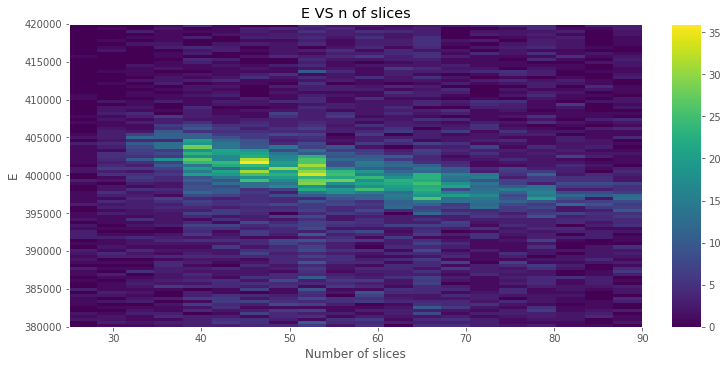

In [41]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(descape_df['nslices'], descape_df['e'] , bins=[.2*nbins, nbins], range=((25, 90),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_e.colorbar(hist_enslices[3], ax = ax_enslices)

In [17]:
# PROFILE UNDER CONSTRUCTION

In [ ]:
## Profile construction
nslices = np.unique(Cs_df['nslices'])

n_merg = 10
nslices_merged = np.array([nslices[n_merg*i:n_merg*(i+1)] for i in range(0, int(len(nslices)/n_merg))])

cut = 500
profile = pd.DataFrame(columns=['nslices', 'Eph', 'sig', 'chisq'])


for nslices in nslices_merged:
    
    cdf = Cs_df[(Cs_df.nslices == nslices[0]) & ((Cs_df.nslices == nslices[1]))]
    
    if len(cdf)<cut: continue
    
    #Fitting
    ydata, xdata = np.histogram(cdf['e'], bins=nbins, range = (Emin,Emax))
    xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

    guess = [np.mean(cdf['e']), np.std(cdf['e']), np.max(ydata), -1, np.mean(ydata)]
    
    popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))
    chi = chisq(F, popt, xdata, ydata)
    
    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    
    profile = profile.append({'nslices': nsl, 'Eph': Eph, 'sig': sig, 'chisq': chi}, ignore_index=True)

In [35]:
nslices

array([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  70,  80, 114])

## 5.2. Other Correlations